In [584]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
import os as os
import re as re

from motors.plot import *
from motors.aesthetics import *
from motors.simulation import Simulation

%matplotlib inline
prepare_plot()

# Compare the flux distribution of backbone and sidechain torsions

## Count the data

In [572]:
pka_data_directory = '../../md-data/pka-md-data/'
pka_apo = pka_data_directory + 'apo/'
pka_bound = pka_data_directory + 'atpmg/'

In [568]:
apo_all = glob(pka_apo + '*')
apo_phi = glob(pka_apo + 'phi*')
apo_psi = glob(pka_apo + 'psi*')
apo_omega = glob(pka_apo + 'omega*')

bound_all = glob(pka_bound + '*')
bound_phi = glob(pka_bound + 'phi*')
bound_psi = glob(pka_bound + 'psi*')

print(f'{len(apo_all)} total apo angles, {len(bound_all)} total bound angles in PKA dataset.')
print(f'{len(apo_phi)} phi angles, {len(apo_psi)} psi angles, {len(apo_omega)} omega angles in dataset.')

1341 total apo angles, 1341 total bound angles in PKA dataset.
336 phi angles, 336 psi angles, 0 omega angles in dataset.


There were no omega backbone angles calculated in this dataset, which matches my recollection.

## Load in the files for a quick spot check

In [573]:
def load_files(files):
    data = np.zeros((len(files), 60))
    for (index, file) in enumerate(files):
        datum = np.genfromtxt(file, delimiter=',', skip_header=1)
        data[index, :] = datum
    return data

In [574]:
apo_phi_files = load_files(apo_phi)
bound_phi_files = load_files(bound_phi)

apo_psi_files = load_files(apo_psi)
bound_psi_files = load_files(bound_psi)

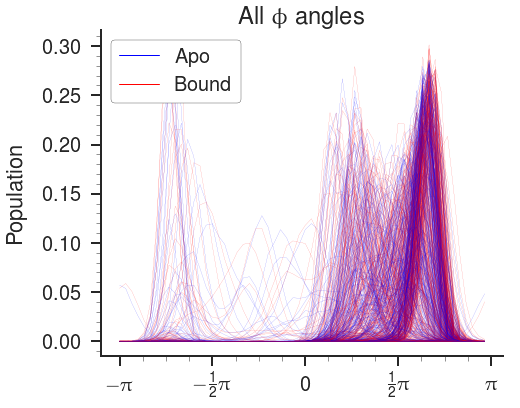

In [575]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])

for index, (apo, bound) in enumerate(zip(apo_phi_files, bound_phi_files)):
    ax1.plot(apo, c='b', lw=0.1, label='Apo' if index == 0 else '')
    ax1.plot(bound, c='r', lw=0.1, label='Bound' if index == 0 else '')
ax1.set_title(r'All $\phi$ angles')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels(
    [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)
for l in legend.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)

paper_plot(fig)

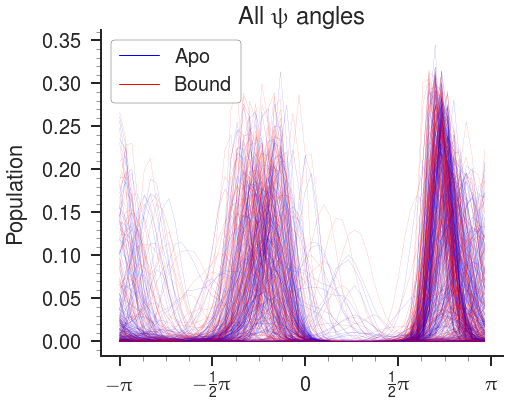

In [576]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])


for index, (apo, bound) in enumerate(zip(apo_psi_files, bound_psi_files)):
    ax1.plot(apo, c='b', lw=0.1, label='Apo' if index == 0 else '')
    ax1.plot(bound, c='r', lw=0.1, label='Bound' if index == 0 else '')
    
ax1.set_title(r'All $\psi$ angles')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels(
    [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)
for l in legend.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)

paper_plot(fig)

## Find a backbone angle with a very similar shape in bound protein conformations, for illustrative purposes...

In [213]:
df = pd.DataFrame()
apo_psi_files = glob(pka_apo + 'psi*')

for index, (apo, bound) in enumerate(zip(apo_psi, bound_psi)):
    # Subtract the difference between the two surfaces...
    difference = sum(apo - bound)
    df = df.append(pd.DataFrame({
        'Index' : index, 
        'File' : apo_psi_files[index],
        'Difference' : difference
    }, index=[0]), ignore_index=True)

In [225]:
df.ix[df['Difference'].idxmin()]['File']

'../../md-data/pka-md-data/apo/psiPHE333_chi_pop_hist_targ.txt'

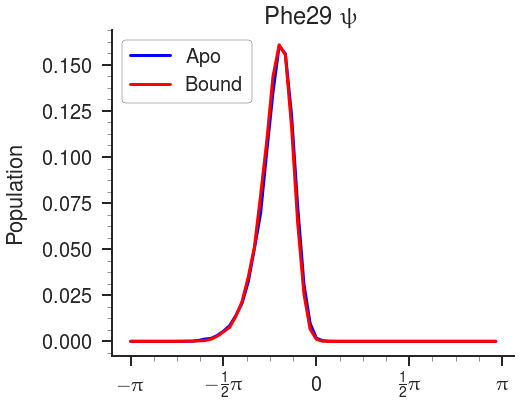

In [577]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])

apo = np.genfromtxt('../../md-data/pka-md-data/apo/psiPHE29_chi_pop_hist_targ.txt', delimiter=',', skip_header=1)
bound = np.genfromtxt('../../md-data/pka-md-data/atpmg/psiPHE29_chi_pop_hist_ref.txt', delimiter=',', skip_header=1)

ax1.plot(apo, c='b', lw=3, label='Apo')
ax1.plot(bound, c='r', lw=3, label='Bound')
    
ax1.set_title(r'Phe29 $\psi$')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels([r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)

paper_plot(fig)

## Read in pre-computed data and separate the backbone torsions and sidechains...

In [578]:
calculation = False

In [444]:
if calculation:
    df = pd.DataFrame()

    pka_dir = '../../md-data/pka-md-data/'
    pka_files = sorted(glob(pka_dir + 'apo/' + '*'))
    names = []

    for file in range(len(pka_files)):
        name = os.path.splitext(os.path.basename(pka_files[file]))[0]
        name = re.search('^[^_]*', name).group(0)        
        if re.search('chi3ASN*', name):
            continue
        if re.search('chi5LYS*', name):
            continue
        if re.search('chi1CYM*', name):
            continue
        names.append(name)

    print(f'Found {len(names)} files...')

    for name in names:
        this = Simulation(data_source='pka_md_data')
        this.cSubstrate = 1.0
        this.name = name
        this.simulate()
        
        directional_flux = np.mean(this.flux_u + this.flux_b)
        # Make all flux on each surface positive
        unbound_flux = abs(this.flux_u)
        bound_flux = abs(this.flux_b)
        # Now find the maximum on either surface
        max_unbound = max(unbound_flux)
        max_bound = max(bound_flux)
        driven_flux = max([max_unbound, max_bound])

        df = df.append(pd.DataFrame({'Concentration': 1.0,
                                'Directional flux': directional_flux,
                                'Driven flux': driven_flux,
                                'File': name,
                                }, index=[0]), ignore_index=True)
else:
    pka_pickle = pd.read_pickle('../../motors/precomputed-pickles/pka-concentration-scan.pickle')
    pka = return_concentration_slice(pka_pickle, -2.0)

In [446]:
side_chains = pka[~pka.File.str.contains("phi|psi")]
back_bones = pka[pka.File.str.contains("phi|psi")]

## Filter the dataframes to look at "high flux" -- interesting -- torsions...

In [586]:
high_flux = pka[pka['Directional flux'].abs().values > 1]['Directional flux'].abs().values
high_flux_sc = side_chains[side_chains['Directional flux'].abs().values > 1]['Directional flux'].abs().values
high_flux_bb = back_bones[back_bones['Directional flux'].abs().values > 1]['Directional flux'].abs().values

In [594]:
print(f'{len(high_flux)} angles have high directional flux at this concentration.')
print(f'{len(high_flux_bb)} ({len(high_flux_bb) / len(high_flux) * 100:1.0f}%) backbone.')
print(f'{len(high_flux_sc)} ({len(high_flux_sc) / len(high_flux) * 100:1.0f}%) side chain.')

140 angles have high directional flux at this concentration.
38 (27%) backbone.
102 (73%) side chain.


## Look at percent backbone as a function of "high" flux threshold...

In [580]:
cmap = sns.color_palette("Paired", 10)

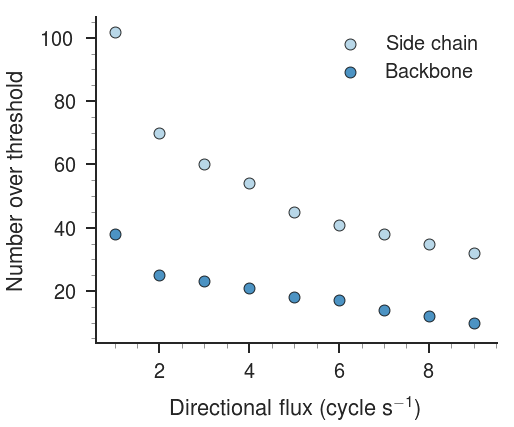

In [611]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

for index, threshold in enumerate(range(1, 10, 1)):
    threshold_flux = pka[pka['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    threshold_sc = side_chains[side_chains['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    threshold_bb = back_bones[back_bones['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    percent_bb = len(threshold_bb) / len(threshold_flux) * 100
    ax.scatter(threshold, len(threshold_sc), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[0], 
               label='Side chain' if index==0 else '')
    ax.scatter(threshold, len(threshold_bb), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[1], 
               label='Backbone' if index==0 else '')
ax.legend()
# ax.set_title('Number backbone torsions as a function of flux')
ax.set_ylabel('Number over threshold')
ax.set_xlabel('Directional flux (cycle s$^{{-1}}$)')
paper_plot(fig)

Edge, Edge, Count
0.0 3.5 46
3.5 7.0 18
7.0 10.5 7
10.5 14.0 7
14.0 17.5 5
17.5 21.0 5
21.0 24.5 3
24.5 28.0 4
28.0 31.5 3
31.5 35.0 1
35.0 38.5 1
38.5 42.0 0
42.0 45.5 0
45.5 49.0 0
49.0 52.5 0
52.5 56.0 1
56.0 59.5 0
59.5 63.0 0
63.0 66.5 1
66.5 70.0 0
Edge, Edge, Count
0.0 3.5 17
3.5 7.0 7
7.0 10.5 7
10.5 14.0 0
14.0 17.5 0
17.5 21.0 2
21.0 24.5 2
24.5 28.0 1
28.0 31.5 0
31.5 35.0 0
35.0 38.5 0
38.5 42.0 1
42.0 45.5 1
45.5 49.0 0
49.0 52.5 0
52.5 56.0 0
56.0 59.5 0
59.5 63.0 0
63.0 66.5 0
66.5 70.0 0


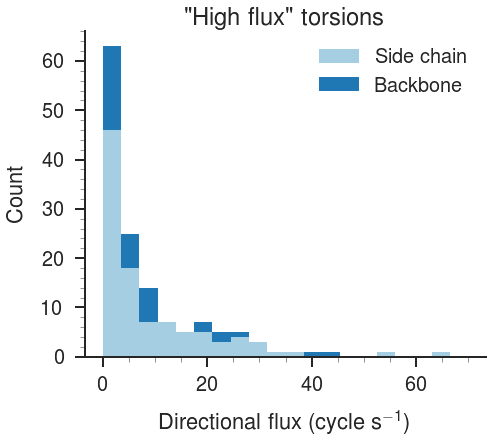

In [581]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

hist_sc, bin_edges = np.histogram(high_flux_sc, bins=20, range=(0,70))
mids = bin_edges[1:] - np.diff(bin_edges)/2
width = bin_edges[1] - bin_edges[0]
rects = ax.bar(mids, hist_sc, width=width, color=cmap[0], label='Side chain')

print('Edge, Edge, Count')
for i in range(len(hist)):
    print(bin_edges[i], bin_edges[i+1], hist_sc[i])

    
hist_bb, bin_edges = np.histogram(high_flux_bb, bins=20, range=(0,70))
mids = bin_edges[1:] - np.diff(bin_edges)/2
width = bin_edges[1] - bin_edges[0]
rects = ax.bar(mids, hist_bb, width=width, color=cmap[1], bottom=hist_sc, label='Backbone')

print('Edge, Edge, Count')
for i in range(len(hist)):
    print(bin_edges[i], bin_edges[i+1], hist_bb[i])

ax.legend()
ax.set_title('"High flux" torsions')
ax.set_ylabel('Count')
ax.set_xlabel('Directional flux (cycle s$^{{-1}}$)')
paper_plot(fig)

## Pick a random backbone angle that has "high flux" and investigate...

In [582]:
high_flux[high_flux['File'].str.contains('psi')].head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
54604,-2.0,-6.930801,108.175771,psiALA110,20.707825,-0.00005,0.000175,110
54629,-2.0,-1.143464,12.651134,psiARG180,5.601375,-0.01799,0.010031,180
54635,-2.0,-1.984581,29.652094,psiARG322,8.207853,-0.01899,0.018574,322
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,0.035493,269
54647,-2.0,4.387149,47.312053,psiASN312,11.455164,0.00169,0.003722,312


Let's look at psiALA110...

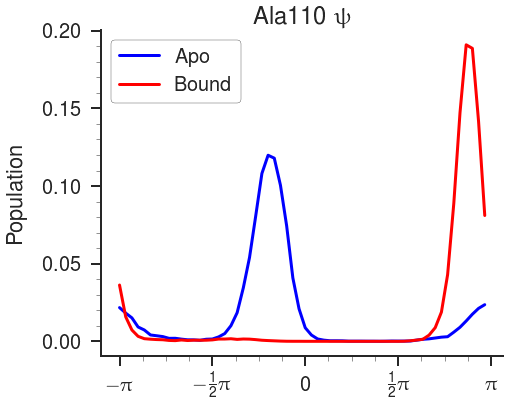

In [585]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])

apo = np.genfromtxt('../../md-data/pka-md-data/apo/psiALA110_chi_pop_hist_targ.txt', delimiter=',', skip_header=1)
bound = np.genfromtxt('../../md-data/pka-md-data/atpmg/psiALA110_chi_pop_hist_ref.txt', delimiter=',', skip_header=1)

ax1.plot(apo, c='b', lw=3, label='Apo')
ax1.plot(bound, c='r', lw=3, label='Bound')
    
ax1.set_title(r'Ala110 $\psi$')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels([r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)

paper_plot(fig)

In [433]:
this = Simulation(data_source='pka_md_data')
this.name = 'psiALA110'
this.cSubstrate = 10**-2.0
this.simulate(directory='/home/dslochower/data/projects/nonequilibrium-master/md-data/pka-md-data/')

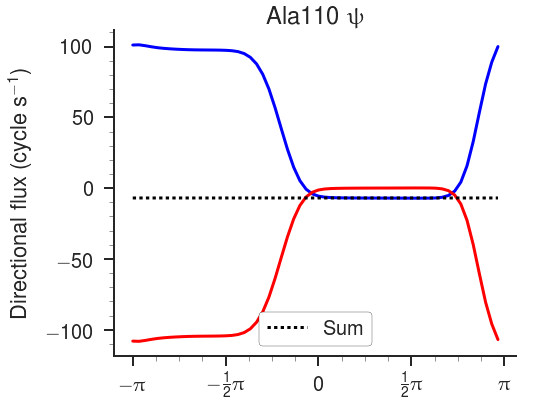

In [457]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])

ax1.plot(this.flux_u, c='b', lw=3)
ax1.plot(this.flux_b, c='r', lw=3)
ax1.plot(this.flux_u + this.flux_b, c='k', lw=3, ls=':', label='Sum')

    
ax1.set_title(r'Ala110 $\psi$')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels([r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
# ax1.set_xlabel(r'Angle')
ax1.set_ylabel(r'Directional flux (cycle s$^{-1}$)')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=0)

paper_plot(fig)

# Find how much work can be produced by a cycle of reciprocating motion

In [466]:
pka[pka['Driven flux'] > 10].sort_values('Driven flux').head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53959,-2.0,-0.000400,10.001350,chi2GLU107,3.036241,0.00000,0.000000e+00,107
54246,-2.0,-0.068681,10.011068,chi4LYS271,1.853816,0.00000,0.000000e+00,271
54409,-2.0,0.000149,10.036953,phiILE195,3.192221,0.00000,0.000000e+00,195
54070,-2.0,-0.360129,10.086928,chi2LYS67,3.331340,0.00000,0.000000e+00,67
54407,-2.0,-0.000098,10.089635,phiILE160,4.972032,-0.00001,2.815827e-10,160


In [496]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2GLU107'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 0.00068072
Reciprocating flux = 10.00165558


C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +6.81e-04  cycle second**-1
Peak                      +1.00e+01  cycle second**-1


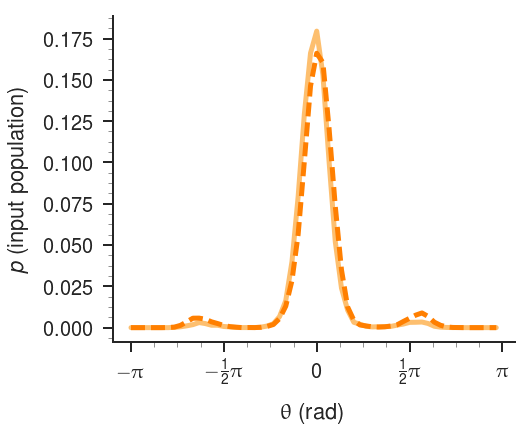

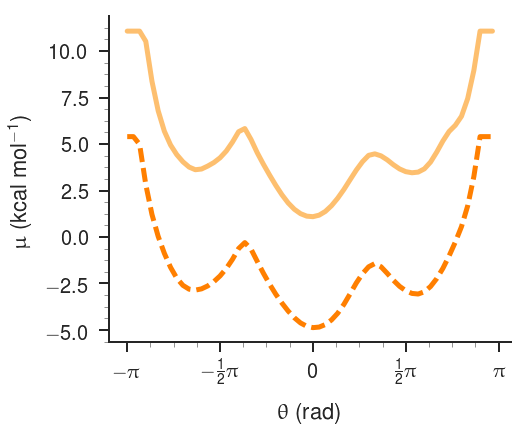

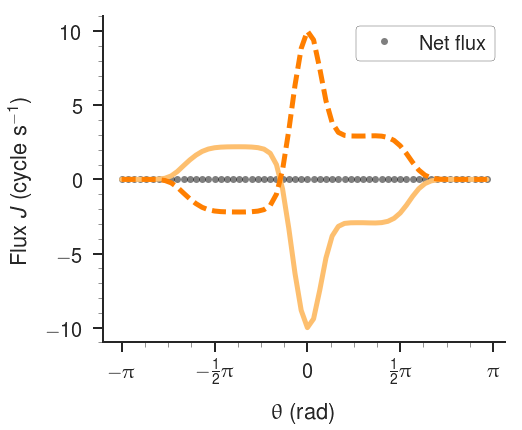

In [490]:
plot_input(this)
plot_energy(this)
plot_flux(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         -1.13e+01  cycle second**-1
Peak                      +1.34e+00  cycle second**-1
-------------------------
Applied load              +7.00e-02  kcal mol**-1 cycle**-1
Power generated           -7.92e-01  kcal mol**-1 second**-1


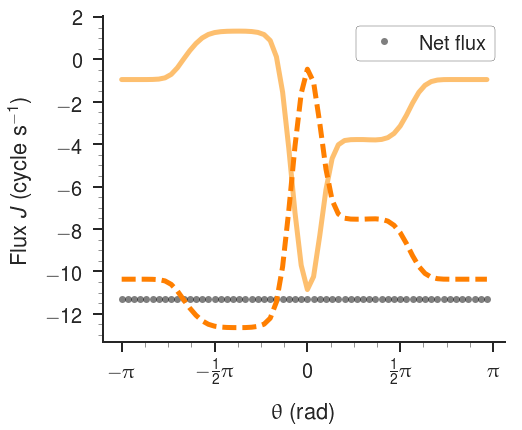

In [479]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2GLU107'
this.load = True
this.load_slope = 0.07
this.cSubstrate = 10**-2.0
this.simulate()
plot_flux(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +4.84e+00  cycle second**-1
Peak                      +1.45e+01  cycle second**-1
-------------------------
Applied load              -3.00e-02  kcal mol**-1 cycle**-1
Power generated           -1.45e-01  kcal mol**-1 second**-1


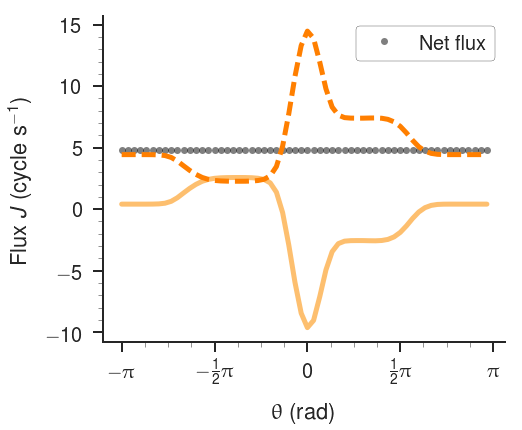

In [481]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2GLU107'
this.load = True
this.load_slope = -0.03
this.cSubstrate = 10**-2.0
this.simulate()
plot_flux(this)

# PKA torsion with the highest amount of work

In [535]:
def plot_load(this, save=False, filename=None):
    """
    Plot the unbound and bound energy surfaces with a constant added load.
    """

    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(range(this.bins), [this.unbound[i] + this.load_function(i) for i in range(this.bins)],
             c='k', ls='--', lw=2)
    ax1.plot(range(this.bins), this.unbound, c=this.unbound_clr)
    ax1.plot(range(this.bins), [this.bound[i] + this.load_function(i) for i in range(this.bins)],
             c='k', ls='--', lw=2)
    ax1.plot(range(this.bins), this.bound, c=this.bound_clr, ls='--')

    ax1.set_xticks([0, this.bins / 4, this.bins /
                    2, 3 * this.bins / 4, this.bins])
    ax1.set_xticklabels(
        [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
    ax1.set_xlabel(r'$\theta$ (rad)')
    ax1.set_ylabel(r'Free energy (kcal mol$^{-1}$)')
    paper_plot(fig, scientific=False)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')

In [537]:
def plot_flux(this, save=False, filename=None):
    """
    Plot the intrasurface flux separately and as a sum. The intrasurface flux
    is the directional flux. This also prints the simulation parameters.
    """

    print_parameter('C', this.C_intersurface, 'second**-1')
    print_parameter('D', this.D, 'degrees**2 second**-1')
    print_parameter('k_{cat}', this.catalytic_rate, 'second**-1')
    print_parameter('[S]', this.cSubstrate, 'M')
    print_parameter('dt', this.dt, 'second')
    print('-' * 25)
    print_parameter('Intrasurface flux', np.mean(
        this.flux_u + this.flux_b), 'cycle second**-1')
    print_parameter('Peak', np.max(
        np.hstack((this.flux_u, this.flux_b))), 'cycle second**-1')
    if this.load:
        print('-' * 25)
        applied_load = this.load_slope
        power = applied_load * np.mean(this.flux_u + this.flux_b)
        print_parameter('Applied load', applied_load, 'kcal mol**-1 cycle**-1')
        print_parameter('Power generated', power, 'kcal mol**-1 second**-1')

    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(range(this.bins), this.flux_u, c=this.unbound_clr)
    ax1.plot(range(this.bins), this.flux_b, c=this.bound_clr, ls='--')
    ax1.plot(range(this.bins), this.flux_u + this.flux_b, 'o', c='k',
             lw=2, alpha=0.5, zorder=-1, label='Net flux')
    ax1.set_xticks([0, this.bins / 4, this.bins /
                    2, 3 * this.bins / 4, this.bins])
    ax1.set_xticklabels(
        [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
    ax1.axhline(y=0, ls=':', lw=1, c='k')
    ax1.set_xlabel(r'$\theta$ (rad)')
    ax1.set_ylabel('Flux $J$ (cycle s$^{-1}$)')
    ax1.legend(frameon=True, loc=1, framealpha=1.0, edgecolor='k')
    paper_plot(fig, scientific=False)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')

In [485]:
pka

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53600,-2.0,-0.019790,4.854406,chi1ARG119,1.534052,-0.00001,8.203339e-08,119
53601,-2.0,-0.000187,24.656485,chi1ARG120,7.149765,0.00000,0.000000e+00,120
53602,-2.0,-0.236584,11.431478,chi1ARG123,3.202416,-0.00002,1.806208e-06,123
53603,-2.0,-0.150923,2.012519,chi1ARG130,0.769793,-0.00082,7.907613e-05,130
53604,-2.0,29.446949,38.853395,chi1ARG151,11.967190,0.04399,6.639273e-01,151
53605,-2.0,0.454684,8.300234,chi1ARG176,4.249127,0.00001,2.609954e-06,176
53606,-2.0,5.608285,26.678617,chi1ARG180,6.769311,0.00009,2.383628e-04,180
53607,-2.0,-1.350012,11.028525,chi1ARG242,2.070499,-0.00001,1.907840e-06,242
53608,-2.0,-0.014410,13.793916,chi1ARG256,4.105831,-0.00007,4.726976e-07,256
53609,-2.0,0.002686,16.703192,chi1ARG266,8.574698,0.00002,1.201833e-07,266


In [500]:
# pka.sort_values(by='Max power', ascending=False)
pka.reindex(pka['Max power'].abs().sort_values(ascending=False).index).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,14.753445,194
53632,-2.0,30.125165,42.925922,chi1ASP152,8.379632,0.30099,4.441574,152
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842,194
54921,-2.0,-24.842157,92.932294,psiVAL109,15.664651,-0.22099,2.767213,109
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342,157


In [501]:
pka.reindex(pka['Driven flux'].abs().sort_values(ascending=False).index).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342e+00,157
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842e+00,194
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,1.475344e+01,194
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,3.549260e-02,269
54377,-2.0,0.012270,113.439102,phiGLY112,12.143105,0.00003,1.880635e-07,112


In [502]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2ASN157'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 14.32191781
Reciprocating flux = 128.19059104


In [504]:
pka.sort_values(['Driven flux', 'Directional flux'], ascending=[False, True]).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342e+00,157
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842e+00,194
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,1.475344e+01,194
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,3.549260e-02,269
54377,-2.0,0.012270,113.439102,phiGLY112,12.143105,0.00003,1.880635e-07,112


In [505]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 0.01148320
Reciprocating flux = 113.43909098


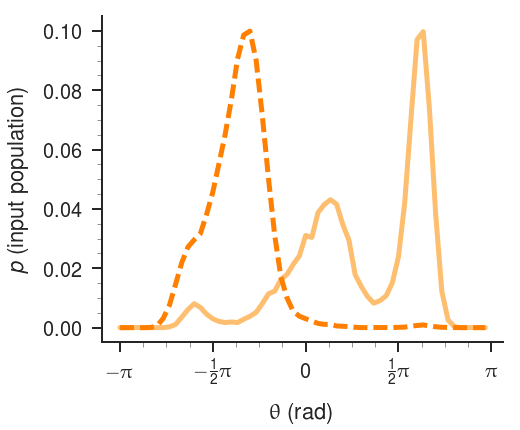

In [508]:
plot_input(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.15e-02  cycle second**-1
Peak                      +1.13e+02  cycle second**-1


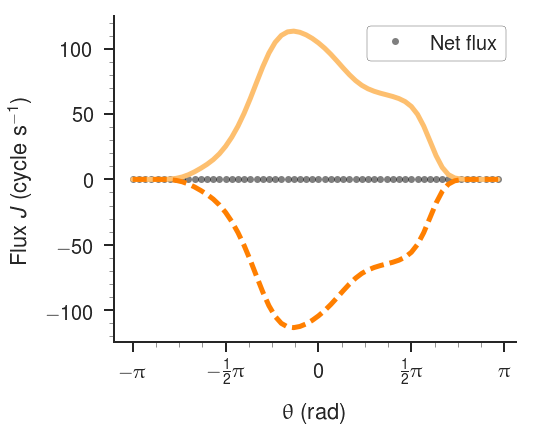

In [510]:
plot_flux(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.47e+02  cycle second**-1
Peak                      +1.45e+02  cycle second**-1
-------------------------
Applied load              -7.00e-01  kcal mol**-1 cycle**-1
Power generated           -1.03e+02  kcal mol**-1 second**-1


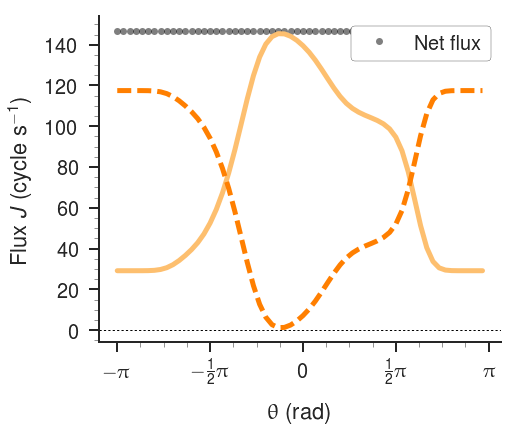

In [538]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = True
this.load_slope = -0.7
this.simulate()

plot_flux(this)

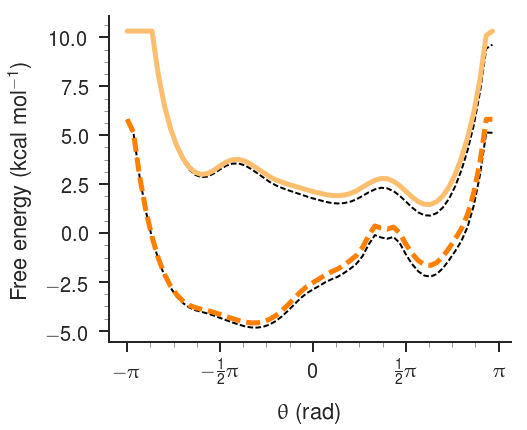

In [539]:
plot_load(this)

# Quick check...

In [560]:
for load_slope in np.arange(0, -0.7, -0.01):

    this = Simulation(data_source='pka_md_data')
    this.name = 'phiGLY112'
    this.cSubstrate = 10**-2.0
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    print(f'{load_slope:+2f}\t{np.min(this.flux_b):+2f}\t{np.min(this.flux_b) * load_slope:+2f}')

+0.000000	-113.427417	-0.000000
-0.010000	-112.169777	+1.121698
-0.020000	-110.903339	+2.218067
-0.030000	-109.628576	+3.288857
-0.040000	-108.345013	+4.333801
-0.050000	-107.052485	+5.352624
-0.060000	-105.755132	+6.345308
-0.070000	-104.443746	+7.311062
-0.080000	-103.129528	+8.250362
-0.090000	-101.803024	+9.162272
-0.100000	-100.467493	+10.046749
-0.110000	-99.126167	+10.903878
-0.120000	-97.776742	+11.733209
-0.130000	-96.411901	+12.533547
-0.140000	-95.041152	+13.305761
-0.150000	-93.660849	+14.049127
-0.160000	-92.271666	+14.763467
-0.170000	-90.868220	+15.447597
-0.180000	-89.460796	+16.102943
-0.190000	-88.041024	+16.727795
-0.200000	-86.609388	+17.321878
-0.210000	-85.171079	+17.885927
-0.220000	-83.718160	+18.417995
-0.230000	-82.258183	+18.919382
-0.240000	-80.787229	+19.388935
-0.250000	-79.300972	+19.825243
-0.260000	-77.810738	+20.230792
-0.270000	-76.304900	+20.602323
-0.280000	-74.785922	+20.940058
-0.290000	-73.259136	+21.245149
-0.300000	-71.718639	+21.515592
-0.3100

In [562]:
for load_slope in np.arange(0, 1.5, 0.05):

    this = Simulation(data_source='pka_md_data')
    this.name = 'phiGLY112'
    this.cSubstrate = 10**-2.0
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    print(f'{load_slope:+0.2f}\t{np.max(this.flux_u):+0.2f}\t{np.max(this.flux_u) * load_slope:+0.2f}')

+0.00	+113.44	+0.00
+0.05	+110.87	+5.54
+0.10	+108.24	+10.82
+0.15	+105.55	+15.83
+0.20	+102.79	+20.56
+0.25	+99.97	+24.99
+0.30	+97.07	+29.12
+0.35	+94.10	+32.94
+0.40	+91.05	+36.42
+0.45	+87.91	+39.56
+0.50	+84.75	+42.37
+0.55	+81.49	+44.82
+0.60	+78.14	+46.88
+0.65	+74.68	+48.54
+0.70	+71.11	+49.78
+0.75	+67.43	+50.57
+0.80	+63.63	+50.91
+0.85	+59.71	+50.75
+0.90	+55.66	+50.09
+0.95	+51.47	+48.90


/home/dslochower/hgst-3tb-data/projects/nonequilibrium-master/motors/simulation.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


+1.00	+47.14	+47.14
+1.05	+42.67	+44.80
+1.10	+38.04	+41.84
+1.15	+33.25	+38.24
+1.20	+28.30	+33.96
+1.25	+23.18	+28.98
+1.30	+17.88	+23.25
+1.35	+12.40	+16.74
+1.40	+6.73	+9.42
+1.45	+0.86	+1.24
